In [1]:
import torch
import sys
sys.path.append("../")
from config import *
from models.common import load_saved_state
from datasets import get_dataset_chw, get_dataset_info, get_dataset_loaders
import matplotlib.pyplot as plt
from models.common import (
    Functional,
    edl_loss,
    edl_probs,
    gather_samples,
    margin_loss,
)

In [6]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

os.environ["MODEL_NAME"] = "rescaps"
os.environ["MANIFOLD_D"] = "50"
os.environ["CV_MODE"] = "k-fold"
os.environ["CV_FOLDS"] = "10"
os.environ["DATASET_NAME"] = "AMRB2_species.4"

In [7]:
torch.cuda.device_count()

0

In [8]:
config = load_config()

config.image_chw = get_dataset_chw(
        dataset_name=config.dataset_name,
)

config.dataset_info = get_dataset_info(
    dataset_name=config.dataset_name,
    data_root=config.data_dir,
    cv_mode=config.cv_mode,
)

INFO:root:LOG_LEVEL=INFO
INFO:root:DATA_DIR=/n/holyscratch01/wadduwage_lab/yasith/datasets
INFO:root:DATASET_NAME=AMRB2_species.4
INFO:root:CV_FOLDS=10
INFO:root:CV_MODE=k-fold
INFO:root:MODEL_NAME=rescaps
INFO:root:EXPERIMENT_BASE=/n/home12/ramith/experiments/ood_flows
INFO:root:MANIFOLD_D=50
INFO:root:BATCH_SIZE=128
INFO:root:OPTIM_LR=0.001
INFO:root:OPTIM_M=0.5
INFO:root:TRAIN_EPOCHS=100
INFO:root:EXC_RESUME=1
INFO:root:Using device: cpu
INFO:root:Dataset info: /n/holyscratch01/wadduwage_lab/yasith/datasets/AMRB2/info.json


In [9]:
train_loader, test_loader = get_dataset_loaders(
        dataset_name = config.dataset_name,
        batch_size_train = 32,
        batch_size_test = 32,
        data_root = "/n/holyscratch01/wadduwage_lab/yasith/datasets",
        cv_k = config.cv_k,
        cv_folds = config.cv_folds,
        cv_mode = config.cv_mode,
    )

INFO:root:Dataset file: /n/holyscratch01/wadduwage_lab/yasith/datasets/AMRB2/proc_data.npz
INFO:root:Dataset info: /n/holyscratch01/wadduwage_lab/yasith/datasets/AMRB2/info.json
INFO:root:[preparation] selected labels for k-fold crossval: ['Acinetobacter', 'E_coli', 'K_pneumoniae', 'S_aureus']
INFO:root:Preparing dataset for reading
INFO:root:[preparation] gathered data and filtered outliers
INFO:root:[preparation] selected the k-th crossval fold
INFO:root:[preparation] balanced class distribution
INFO:root:[preparation] generated data_x
INFO:root:[preparation] generated data_y
INFO:root:Prepared dataset in 29.87164306640625 s
INFO:root:Dataset file: /n/holyscratch01/wadduwage_lab/yasith/datasets/AMRB2/proc_data.npz
INFO:root:Dataset info: /n/holyscratch01/wadduwage_lab/yasith/datasets/AMRB2/info.json
INFO:root:[preparation] selected labels for k-fold crossval: ['Acinetobacter', 'E_coli', 'K_pneumoniae', 'S_aureus']
INFO:root:Preparing dataset for reading
INFO:root:[preparation] gather

In [13]:
PATH = "/n/home12/ramith/experiments/ood_flows/AMRB2_species/k-fold-N10-K4-M50_1-17-53.097923/rescaps_model_e100.pth"

device = torch.device('cpu')
weights = torch.load(PATH, map_location=device)

In [14]:
from models import get_model_optimizer_and_step

In [15]:
model, _, _  = get_model_optimizer_and_step(config)

In [16]:
model.load_state_dict(weights)

model.to(device)

ModuleDict(
  (encoder): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(1, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): GroupNorm(1, 4, eps=1e-05, affine=True)
      )
      (conv2): Sequential(
        (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): GroupNorm(1, 4, eps=1e-05, affine=True)
      )
      (conv3): Sequential(
        (0): Conv2d(4, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): GroupNorm(1, 4, eps=1e-05, affine=True)
      )
      (convI): Sequential(
        (0): Conv2d(1, 4, kernel_size=(2, 2), stride=(2, 2), bias=False)
        (1): GroupNorm(1, 4, eps=1e-05, affine=True)
      )
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(4, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): GroupNorm(1, 8, eps=1e-05, affine=True)
      )
      (conv2): Sequential(
        (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), 

In [17]:
encoder = model["encoder"]
classifier = model["classifier"]
decoder = model["decoder"]

In [18]:
# y_z, sel_z_x = classifier(z_x)

In [19]:
# (B, D, K) = z_x.size()

# logits = torch.as_tensor(z_x.norm(p=2, dim=1, keepdim=True))
# print(logits.shape)

# index = logits.argmax(dim=2, keepdim=True).repeat(1, D, 1)
# print(index.shape)

In [24]:
mode = 'train'
filter_only_correct = False


if(mode == 'train'):
    loader = train_loader
else:
    loader = test_loader

In [25]:
tensors = [] 
ys = []

for idx, (x,y) in enumerate(loader):

    z_x = encoder(x.float())
    y_z, sel_z_x = classifier(z_x)
    pY, uY = edl_probs(y_z.detach())
    
    
    pos_to_extract = y.argmax(dim = 1).unsqueeze(-1).unsqueeze(-1).expand(-1, 50, -1)
    
    target_prototypes = z_x.gather(dim = 2, index = pos_to_extract).detach().cpu()
    
    
    #append
    if(filter_only_correct):
        correct_indices = pY.argmax(dim = 1) == y.argmax(dim = 1)
        
        tensors.append(target_prototypes[correct_indices])
        ys.append(y[correct_indices])
    else:
        tensors.append(target_prototypes)
        ys.append(y)
            
        
    
    if(idx > 2):
        break
    
all_target_prototypes = torch.cat(tensors, dim=0)
all_y = torch.cat(ys, dim = 0 )

In [26]:
# plt.imshow(x[example][0])

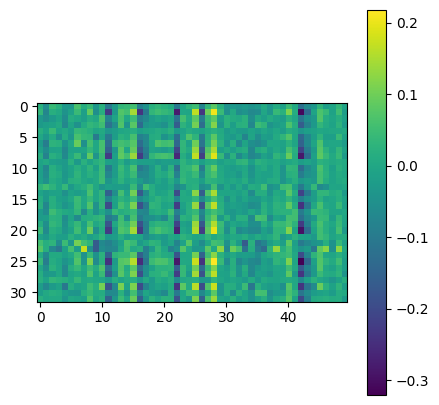

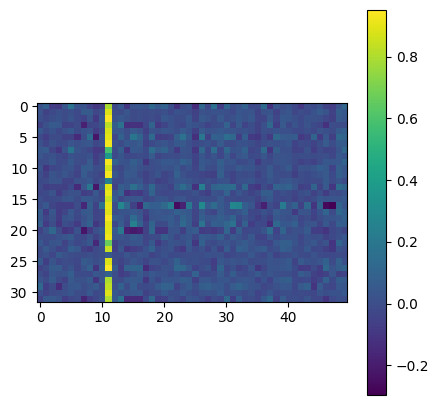

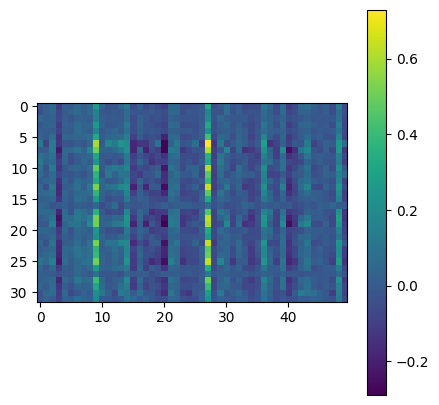

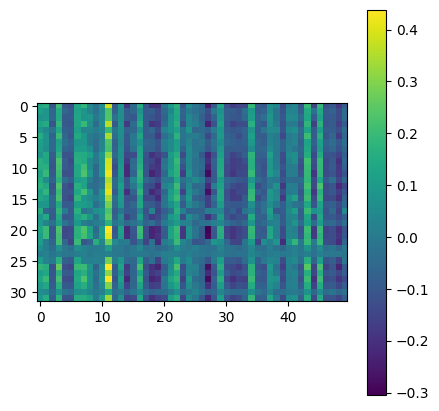

In [27]:
class_means = []

for i in range(0,4):
    mean_vector = all_target_prototypes[all_y.argmax(dim = 1) == i].mean(axis = 0)
    
    class_means.append(mean_vector)
    
    plt.figure(figsize=(5,5))
    plt.imshow(all_target_prototypes[all_y.argmax(dim = 1) == i].detach().cpu())
    plt.savefig(f"mode_{mode}_class_{i}_only_correct_{filter_only_correct}.png")
    
    plt.colorbar()
    
class_reps = torch.cat(class_means, dim=1).T

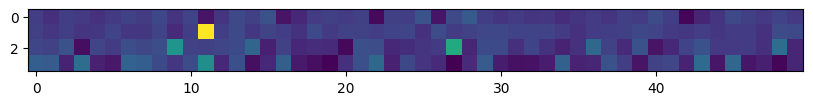

In [28]:
plt.figure(figsize=(10,10))
plt.imshow(class_reps)
plt.savefig("class_reps.png")

In [29]:
pos_variance = torch.var(class_reps, dim = 0).reshape(50,1)


In [30]:
pos_variance.shape[0]

50

/n/home12/ramith/.conda/envs/ood/lib/python3.9/site-packages/numpy/lib/stride_tricks.py:538: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
/n/home12/ramith/.conda/envs/ood/lib/python3.9/site-packages/numpy/lib/stride_tricks.py:538: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [np.array(_m, copy=Fa

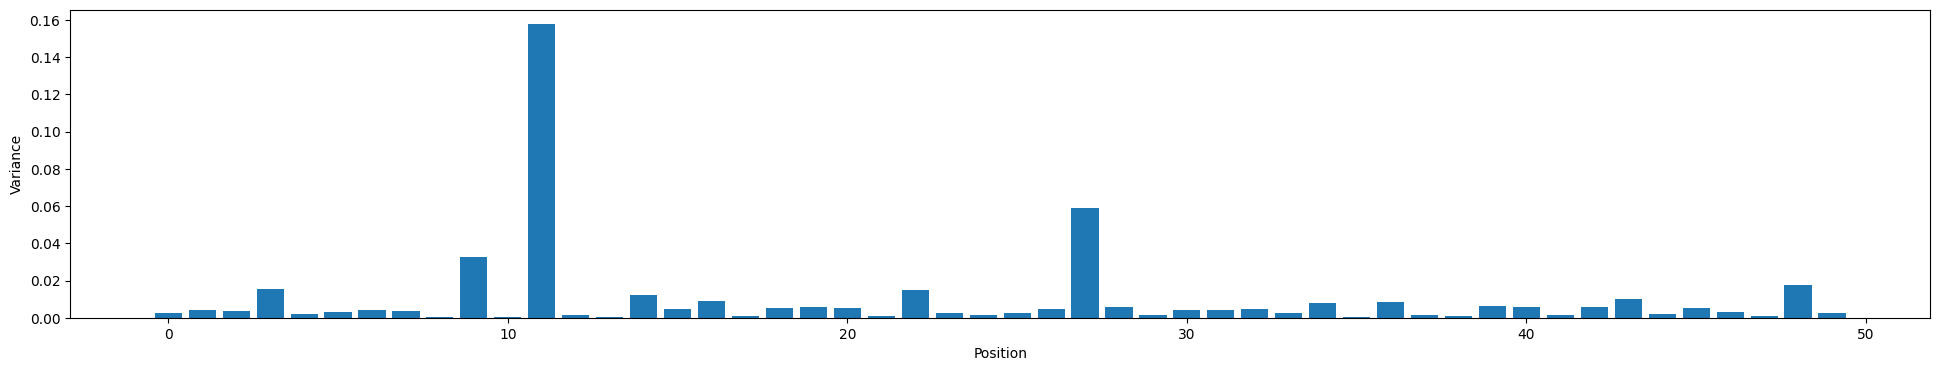

In [31]:
plt.figure(figsize=(24,4))
plt.bar(range(pos_variance.shape[0]),pos_variance)

plt.xlabel('Position')
plt.ylabel('Variance')
plt.savefig("varience_plot.png")

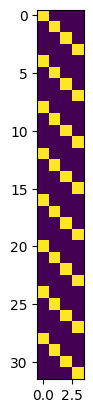

In [35]:
plt.imshow(y)

In [16]:
# pY, uY = edl_probs(y_z.detach())
# pY.argmax(dim = 1) == y.argmax(dim = 1)

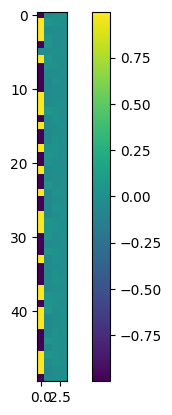

In [17]:
plt.imshow(z_x[0].detach().cpu())
plt.colorbar()

In [27]:
z_x.shape

torch.Size([32, 50, 4])

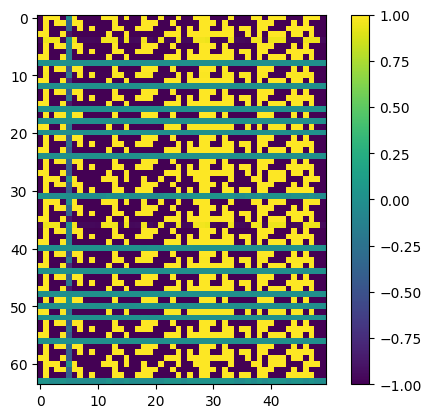

In [91]:
target_prototypes.shape

torch.Size([32, 50, 1])

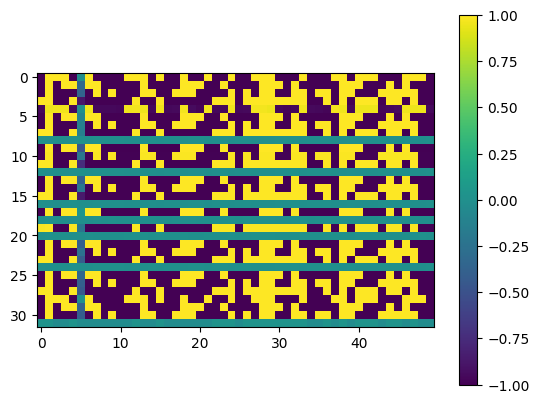

In [81]:
plt.imshow(target_prototypes.detach().cpu())
plt.colorbar()

In [89]:
torch.equal(target_prototypes[1], z_x[1,:,1].reshape(50,1))

True